In [1]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.tytf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('../Data/강남 일별 시간대별 승객유형별 승하차인원 최종.csv')

In [3]:
df.head()

datetime     연  월  일  시간  요일  주말  공휴일  외국인    우대권      일반
0  2022-06-01 05:00:00  2022  6  1   5   2   0    1  6.0  116.0   939.0
1  2022-06-01 06:00:00  2022  6  1   6   2   0    1  0.0  349.0  1085.0
2  2022-06-01 07:00:00  2022  6  1   7   2   0    1  0.0  232.0  1280.0
3  2022-06-01 08:00:00  2022  6  1   8   2   0    1  0.0  205.0  2402.0
4  2022-06-01 09:00:00  2022  6  1   9   2   0    1  1.0  249.0  3740.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14620 entries, 0 to 14619
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  14620 non-null  object 
 1   연         14620 non-null  int64  
 2   월         14620 non-null  int64  
 3   일         14620 non-null  int64  
 4   시간        14620 non-null  int64  
 5   요일        14620 non-null  int64  
 6   주말        14620 non-null  int64  
 7   공휴일       14620 non-null  int64  
 8   외국인       14620 non-null  float64
 9   우대권       14620 non-null  float64
 10  일반        14620 non-null  float64
dtypes: float64(3), int64(7), object(1)
memory usage: 1.2+ MB


In [5]:
# 'datetime' 컬럼을 datetime 형식으로 변환
df['datetime'] = pd.to_datetime(df['datetime'])

# 변환 후 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14620 entries, 0 to 14619
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  14620 non-null  datetime64[ns]
 1   연         14620 non-null  int64         
 2   월         14620 non-null  int64         
 3   일         14620 non-null  int64         
 4   시간        14620 non-null  int64         
 5   요일        14620 non-null  int64         
 6   주말        14620 non-null  int64         
 7   공휴일       14620 non-null  int64         
 8   외국인       14620 non-null  float64       
 9   우대권       14620 non-null  float64       
 10  일반        14620 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(7)
memory usage: 1.2 MB


In [6]:
import pandas as pd

# 기본 비율
base_age_group_ratios = {
    '10대': 0.08,
    '20대': 0.20,
    '30대': 0.35,
    '40대': 0.25,
    '50대 이상': 0.12
}

# 시간대별 가중치
time_age_group_weights = {
    '출근시간': {'10대': 0.6, '20대': 1.2, '30대': 1.5, '40대': 1.4, '50대 이상': 0.8},
    '퇴근시간': {'10대': 0.7, '20대': 1.1, '30대': 1.2, '40대': 1.3, '50대 이상': 1.0},
    '일반시간': {'10대': 1.2, '20대': 0.9, '30대': 0.8, '40대': 0.7, '50대 이상': 1.4}
}

# 요일별 가중치
weekday_age_group_weights = {
    '평일': {'10대': 0.8, '20대': 1.0, '30대': 1.3, '40대': 1.2, '50대 이상': 0.7},
    '주말': {'10대': 1.5, '20대': 1.3, '30대': 0.7, '40대': 0.6, '50대 이상': 1.4},
    '공휴일': {'10대': 1.4, '20대': 1.2, '30대': 0.8, '40대': 0.7, '50대 이상': 1.5}
}

# 시간대 분류
def get_time_period(hour):
    if 7 <= hour <= 9:
        return '출근시간'
    elif 17 <= hour <= 19:
        return '퇴근시간'
    else:
        return '일반시간'

# 요일 분류
def get_weekday_type(is_weekend, is_holiday):
    if is_holiday:
        return '공휴일'
    return '주말' if is_weekend else '평일'

# 나이대별 승객 수 계산
def calculate_age_group_counts(row):
    time_period = get_time_period(row['시간'])
    weekday_type = get_weekday_type(row['주말'], row['공휴일'])
    
    # 시간대와 요일별 가중치를 적용한 나이대 비율 계산
    adjusted_ratios = {
        age_group: base_age_group_ratios[age_group] *
                   time_age_group_weights[time_period][age_group] *
                   weekday_age_group_weights[weekday_type][age_group]
        for age_group in base_age_group_ratios
    }
    
    # 승객 수 계산
    total = sum(adjusted_ratios.values())
    adjusted_ratios = {k: v / total for k, v in adjusted_ratios.items()}  # 비율 정규화
    return {age_group: round(row['일반'] * ratio) for age_group, ratio in adjusted_ratios.items()}  # 소수점 반올림

# 나이대별 승객 수 초기화 및 계산 적용
age_group_columns = ['10대', '20대', '30대', '40대', '50대 이상']

# 각 row에 대해 나이대별 승객 수 계산
for index, row in df.iterrows():
    age_group_counts = calculate_age_group_counts(row)
    for age_group, count in age_group_counts.items():
        df.at[index, age_group] = count

# '일반' 컬럼 삭제 (나이대로 분리되었으므로 불필요)
df = df.drop(columns=['일반'])

# 결과 확인
df.head()

datetime     연  월  일  시간  요일  주말  공휴일  외국인    우대권    10대    20대  \
0 2022-06-01 05:00:00  2022  6  1   5   2   0    1  6.0  116.0  133.0  214.0   
1 2022-06-01 06:00:00  2022  6  1   6   2   0    1  0.0  349.0  154.0  247.0   
2 2022-06-01 07:00:00  2022  6  1   7   2   0    1  0.0  232.0   74.0  317.0   
3 2022-06-01 08:00:00  2022  6  1   8   2   0    1  0.0  205.0  139.0  594.0   
4 2022-06-01 09:00:00  2022  6  1   9   2   0    1  1.0  249.0  216.0  925.0   

      30대    40대  50대 이상  
0   222.0  121.0   249.0  
1   256.0  140.0   288.0  
2   462.0  269.0   158.0  
3   867.0  505.0   297.0  
4  1349.0  787.0   463.0

In [7]:
# 우대권과 외국인을 뒤로 이동시키기
columns_order = [col for col in df.columns if col not in ['우대권', '외국인']] + ['우대권', '외국인']
df = df[columns_order]

In [8]:
df.head()

datetime     연  월  일  시간  요일  주말  공휴일    10대    20대     30대  \
0 2022-06-01 05:00:00  2022  6  1   5   2   0    1  133.0  214.0   222.0   
1 2022-06-01 06:00:00  2022  6  1   6   2   0    1  154.0  247.0   256.0   
2 2022-06-01 07:00:00  2022  6  1   7   2   0    1   74.0  317.0   462.0   
3 2022-06-01 08:00:00  2022  6  1   8   2   0    1  139.0  594.0   867.0   
4 2022-06-01 09:00:00  2022  6  1   9   2   0    1  216.0  925.0  1349.0   

     40대  50대 이상    우대권  외국인  
0  121.0   249.0  116.0  6.0  
1  140.0   288.0  349.0  0.0  
2  269.0   158.0  232.0  0.0  
3  505.0   297.0  205.0  0.0  
4  787.0   463.0  249.0  1.0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14620 entries, 0 to 14619
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  14620 non-null  datetime64[ns]
 1   연         14620 non-null  int64         
 2   월         14620 non-null  int64         
 3   일         14620 non-null  int64         
 4   시간        14620 non-null  int64         
 5   요일        14620 non-null  int64         
 6   주말        14620 non-null  int64         
 7   공휴일       14620 non-null  int64         
 8   10대       14620 non-null  float64       
 9   20대       14620 non-null  float64       
 10  30대       14620 non-null  float64       
 11  40대       14620 non-null  float64       
 12  50대 이상    14620 non-null  float64       
 13  우대권       14620 non-null  float64       
 14  외국인       14620 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(7)
memory usage: 1.7 MB


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# 데이터 준비
features = ['연', '월', '일', '시간', '요일', '주말', '공휴일'] 
targets = ['10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인']

X = df[features]
y = df[targets]

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=5)

# 모델 학습 및 예측
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "KNN": knn_model
}

results = {}

for name, model in models.items():
    # 모델 학습
    model.fit(X_train, y_train)
    # 예측
    y_pred = model.predict(X_test)
    # 평가
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R²": r2}

# 결과 출력
results_df = pd.DataFrame(results).T  # Transpose for better readability
print(results_df)

                         MSE        R²
Random Forest   16848.049211  0.932766
XGBoost         12361.498375  0.951369
KNN            137572.937004  0.823551


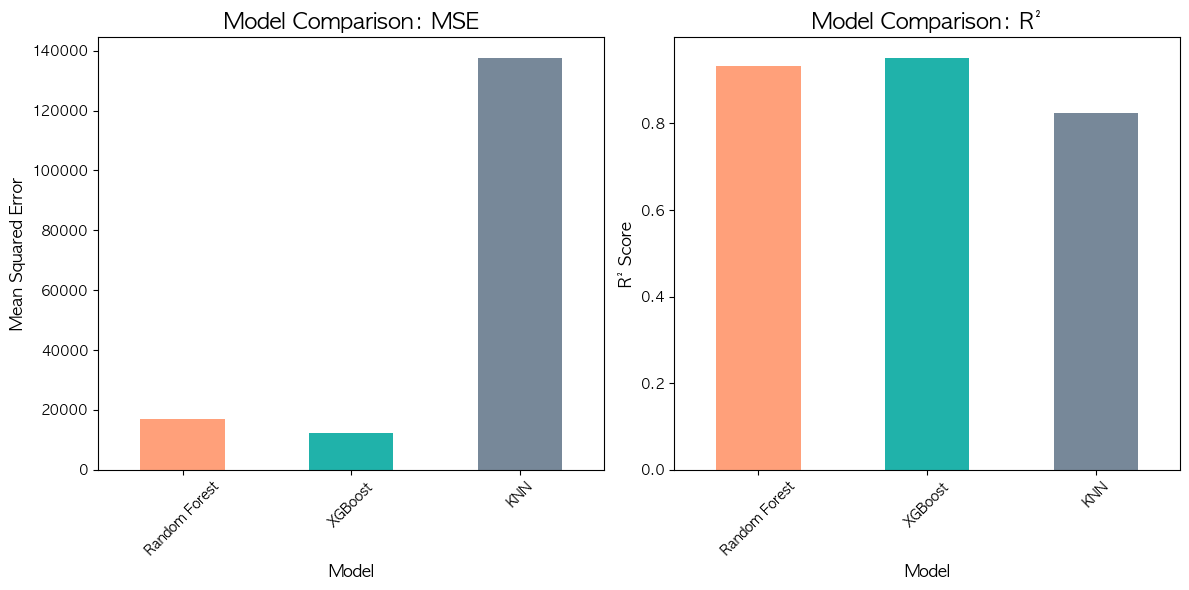

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 6))

# MSE Bar Chart
plt.subplot(1, 2, 1)
results_df["MSE"].plot(kind="bar", color=['#FFA07A', '#20B2AA', '#778899'])
plt.title("Model Comparison: MSE", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45)

# R² Bar Chart
plt.subplot(1, 2, 2)
results_df["R²"].plot(kind="bar", color=['#FFA07A', '#20B2AA', '#778899'])
plt.title("Model Comparison: R²", fontsize=16)
plt.ylabel("R² Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10]
}

# XGBoost 모델 초기화
xgb_model = XGBRegressor(random_state=42)

# GridSearchCV로 최적의 하이퍼파라미터 색
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 R² 점수:", grid_search.best_score_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8; tot

In [22]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# 최적의 하이퍼파라미터를 반영한 XGBoost 모델 초기화
optimized_xgb_model = XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=1,
    n_estimators=100,
    subsample=0.8,
    random_state=42
)

# 모델 학습
optimized_xgb_model.fit(X_train, y_train)

# 모델 평가
y_pred = optimized_xgb_model.predict(X_test)

# 타겟별 점수 계산
target_scores = {}
for i, target in enumerate(y_test.columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    target_scores[target] = {"MSE": mse, "R²": r2}

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(target_scores).T

# 결과 출력
print("최적화된 XGBoost 모델의 타겟별 성능:")
print(results_df)

# 전체 평균 점수 계산
average_mse = results_df['MSE'].mean()
average_r2 = results_df['R²'].mean()

print(f"\n전체 평균 - MSE: {average_mse}")
print(f"전체 평균 - R²: {average_r2}")

최적화된 XGBoost 모델의 타겟별 성능:
                 MSE        R²
10대       904.617855  0.989252
20대      7730.020780  0.988347
30대     38952.107126  0.992143
40대     16455.629691  0.992927
50대 이상   2528.410218  0.988940
우대권      1026.946664  0.990988
외국인        37.122252  0.739493

전체 평균 - MSE: 9662.12208382081
전체 평균 - R²: 0.9545843485981227


In [23]:
from sklearn.model_selection import cross_val_score

# 교차 검증
cv_scores = cross_val_score(optimized_xgb_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

Cross-Validation Scores: [0.76782238 0.91967804 0.93166189 0.93033692 0.9385963 ]
Mean CV Score: 0.8976191070924011


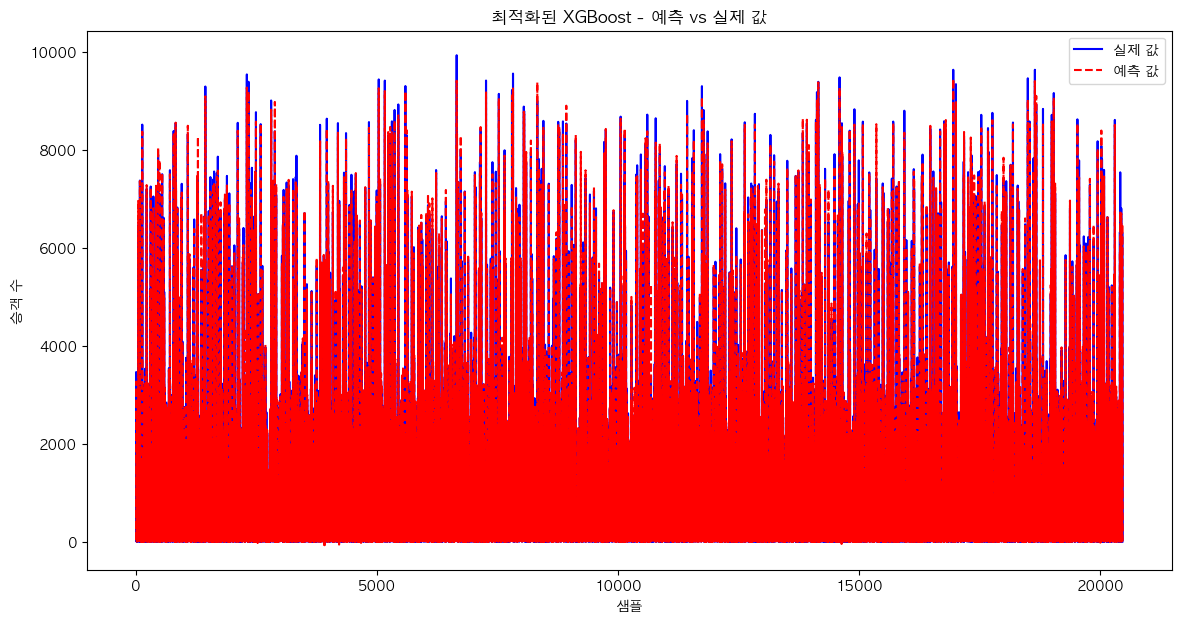

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.values.flatten(), label='실제 값', color='blue')
plt.plot(y_pred.flatten(), label='예측 값', color='red', linestyle='dashed')
plt.legend()
plt.title('최적화된 XGBoost - 예측 vs 실제 값')
plt.xlabel('샘플')
plt.ylabel('승객 수')
plt.show()

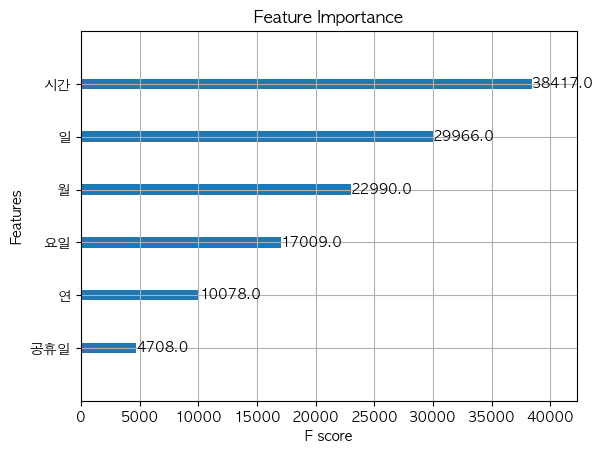

In [17]:
from xgboost import plot_importance

plot_importance(optimized_xgb_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

In [24]:
import pandas as pd
import holidays
from datetime import datetime

# 한국 공휴일 정보
kr_holidays = holidays.KR()

# 특징 생성 함수
def create_features_for_datetime(dt):
    """datetime에서 특징을 생성"""
    return {
        'datetime': dt,
        '연': dt.year,
        '월': dt.month,
        '일': dt.day,
        '시간': dt.hour,
        '요일': dt.weekday(),
        '주말': 1 if dt.weekday() >= 5 else 0,
        '공휴일': 1 if dt in kr_holidays else 0,
    }

# 미래 예측 함수
def predict_passenger_count(model, future_datetime):
    """미래 승객 수 예측"""
    # datetime에서 특징 생성
    feature = create_features_for_datetime(future_datetime)
    feature_df = pd.DataFrame([feature])
    
    # 필요한 입력 데이터만 선택
    feature_columns = ['연', '월', '일', '시간', '요일', '주말', '공휴일']
    feature_input = feature_df[feature_columns]
    
    # 예측 수행
    prediction = model.predict(feature_input)
    
    # 예측 결과 처리: 각 값을 소수점 반올림 및 0보다 작은 값 처리
    prediction = [max(0, round(float(val))) for val in prediction[0]]
    return {
        '10대': prediction[0],
        '20대': prediction[1],
        '30대': prediction[2],
        '40대': prediction[3],
        '50대 이상': prediction[4],
        '우대권': prediction[5],
        '외국인': prediction[6]
    }

# 특정 날짜의 시간대별 예측 함수
def predict_specific_date_all_hours(model, date_input):
    """
    특정 날짜의 0시부터 23시까지 모든 시간대의 승객 수 예측
    1시~4시는 제외
    """
    # date_input을 datetime 형식으로 변환
    specific_date = datetime.strptime(date_input, '%Y%m%d')
    
    predictions = []
    for hour in range(24):
        # 1시~4시 제외
        if 1 <= hour <= 4:
            continue
        current_time = specific_date.replace(hour=hour, minute=0, second=0, microsecond=0)
        predicted_count = predict_passenger_count(model, current_time)
        predictions.append({
            'datetime': current_time.strftime('%Y-%m-%d %H:%M:%S'),
            **predicted_count  # 딕셔너리 병합
        })
    
    # 결과를 데이터프레임으로 반환
    return pd.DataFrame(predictions)

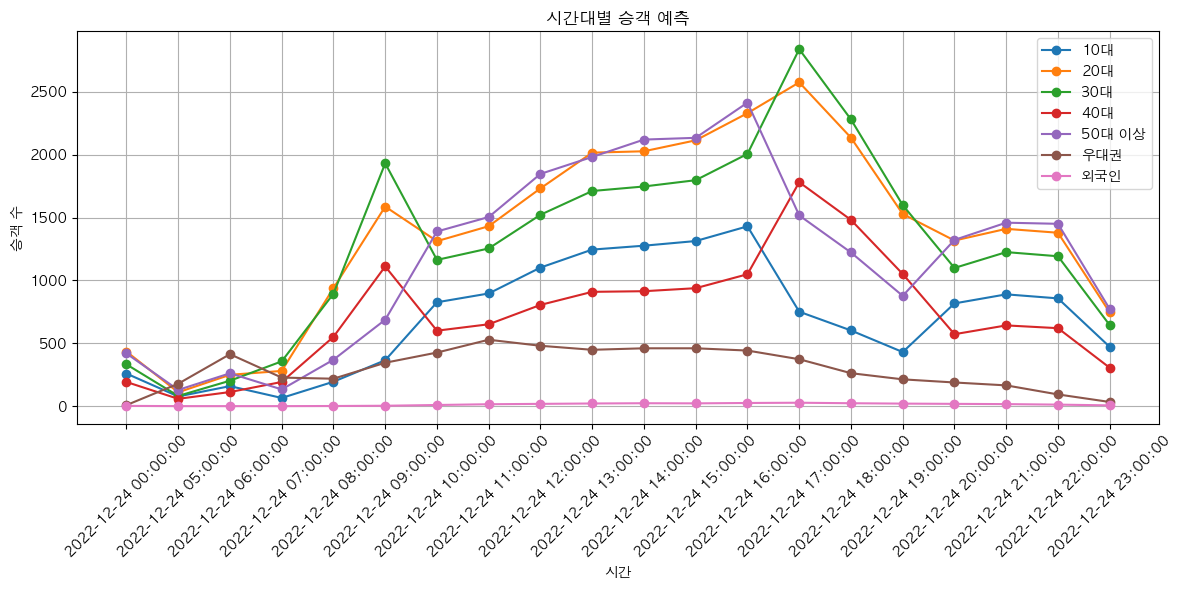

datetime   10대   20대   30대   40대  50대 이상  우대권  외국인  승객수 합계
0   2022-12-24 00:00:00   259   434   332   192     419    8    2    1646
1   2022-12-24 05:00:00    77   110    81    58     129  178    0     633
2   2022-12-24 06:00:00   159   249   202   112     261  413    0    1396
3   2022-12-24 07:00:00    65   280   356   192     133  227    0    1253
4   2022-12-24 08:00:00   194   938   894   551     369  218    1    3165
5   2022-12-24 09:00:00   365  1587  1931  1111     687  345    3    6029
6   2022-12-24 10:00:00   826  1312  1163   600    1389  426    9    5725
7   2022-12-24 11:00:00   896  1431  1254   651    1504  528   15    6279
8   2022-12-24 12:00:00  1102  1732  1522   805    1847  480   18    7506
9   2022-12-24 13:00:00  1245  2016  1711   909    1982  448   21    8332
10  2022-12-24 14:00:00  1276  2027  1747   914    2120  460   23    8567
11  2022-12-24 15:00:00  1313  2114  1797   938    2134  460   22    8778
12  2022-12-24 16:00:00  1430  2330  2006  1049    2414  442   25    9696
13  2022-12-24 17:00:00   751  2575  2839  1781    1517  373   27    9863
14  2022-12-24 18:00:00   602  2135  2280  1481    1222  262   23    8005
15  2022-12-24 19:00:00   430  1528  1599  1051     877  213   20    5718
16  2022-12-24 20:00:00   817  1317  1099   572    1322  188   18    5333
17  2022-12-24 21:00:00   889  1410  1225   642    1459  165   16    5806
18  2022-12-24 22:00:00   857  1379  1192   620    1450   93   12    5603
19  2022-12-24 23:00:00   471   745   644   305     772   33    6    2976

In [25]:
import pandas as pd

# 예측 수행
date_input = "20221224"  # 예측할 날짜 (YYYYMMDD)
predictions_for_date = predict_specific_date_all_hours(optimized_xgb_model, date_input)

# 승객수 합계 추가
predictions_for_date['승객수 합계'] = (
    predictions_for_date['10대'] +
    predictions_for_date['20대'] +
    predictions_for_date['30대'] +
    predictions_for_date['40대'] +
    predictions_for_date['50대 이상'] +
    predictions_for_date['우대권'] +
    predictions_for_date['외국인']
)

import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(12, 6))
for column in ['10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인']:
    plt.plot(predictions_for_date['datetime'], predictions_for_date[column], label=column, marker='o')

plt.xticks(rotation=45)
plt.title("시간대별 승객 예측")
plt.xlabel("시간")
plt.ylabel("승객 수")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

predictions_for_date

In [26]:
# 'datetime' 컬럼을 datetime 형식으로 변환
df['datetime'] = pd.to_datetime(df['datetime'])

# 특정 날짜 필터링
specific_date = "2022-12-23"  # 원하는 날짜 (YYYY-MM-DD)
filtered_data = df[df['datetime'].dt.date == datetime.strptime(specific_date, '%Y-%m-%d').date()]

# 특정 열만 선택
filtered_data = filtered_data[['datetime', '10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인']]

# 숫자형 데이터를 정수로 변환
filtered_data[['10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인']] = filtered_data[
    ['10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인']
].astype(int)

# 승객수 합계 열 추가
filtered_data['승객수 합계'] = filtered_data[['10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인']].sum(axis=1)

# 결과 출력
filtered_data

datetime  10대   20대   30대   40대  50대 이상   우대권  외국인  승객수 합계
4099 2022-12-23 00:00:00   98   229   463   267     150    15    3    1225
4100 2022-12-23 05:00:00   42    99   199   115      64   301    0     820
4101 2022-12-23 06:00:00  157   368   745   430     241   570    0    2511
4102 2022-12-23 07:00:00  168  1048  2980  1834     293   401    0    6724
4103 2022-12-23 08:00:00  358  2239  6368  3919     627   456    0   13967
4104 2022-12-23 09:00:00  331  2067  5879  3618     579   593    0   13067
4105 2022-12-23 10:00:00  543  1272  2572  1484     831   678    5    7385
4106 2022-12-23 11:00:00  470  1102  2228  1285     720   748   15    6568
4107 2022-12-23 12:00:00  504  1180  2386  1377     771   651    9    6878
4108 2022-12-23 13:00:00  607  1423  2878  1660     930   741   22    8261
4109 2022-12-23 14:00:00  581  1362  2754  1589     890   971   20    8167
4110 2022-12-23 15:00:00  705  1652  3341  1927    1079  1111   37    9852
4111 2022-12-23 16:00:00  860  2015  4075  2351    1317   863   28   11509
4112 2022-12-23 17:00:00  551  2708  6720  4800    1034   791   20   16624
4113 2022-12-23 18:00:00  727  3568  8855  6325    1362   517   23   21377
4114 2022-12-23 19:00:00  437  2147  5328  3806     820   337   17   12892
4115 2022-12-23 20:00:00  637  1493  3020  1742     976   255   18    8141
4116 2022-12-23 21:00:00  653  1531  3095  1786    1000   242    7    8314
4117 2022-12-23 22:00:00  657  1540  3115  1797    1006   175   10    8300
4118 2022-12-23 23:00:00  446  1046  2116  1221     684    68    2    5583

In [27]:
from joblib import dump

# 모델 저장
dump(optimized_xgb_model, "../Data/model.joblib")

print("모델이 'model.joblib'로 저장되었습니다.")

모델이 'model.joblib'로 저장되었습니다.
